# Under- and overfitting, model selection

## Preliminaries

In the first set of exercises you had to implement the training and evaluation of the linear regression and $k$-NN methods from scratch in order to practice your `numpy` skills. From this set of exercises onward, you can use the implementations provided in `scikit-learn` or other higher-level libraries. We start this set of exercises by demonstrating some of the features of `scikit-learn`.

For example, implementation of linear regression model fitting with an analytical solution for the parameters is provided by the class `sklearn.linar_model.LinearRegression`. You can train a linear regression model in the following way:

In [1]:
import numpy as np
from sklearn import datasets, linear_model

# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# split the data into training/testing sets
X_train = X[:-20]
X_test = X[-20:]

# split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

# create linear regression object
model = linear_model.LinearRegression()

# train the model using the training dataset
model.fit(X_train, y_train)

LinearRegression()

Let's visualize the training dataset and the learned regression model.

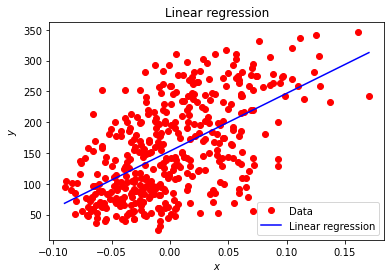

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(X_train, y_train, 'r.', markersize=12)
X_edge = np.array([np.min(X_train, 0), np.max(X_train, 0)])
plt.plot(X_edge, model.predict(X_edge), 'b-')
plt.legend(('Data', 'Linear regression'), loc='lower right')
plt.title('Linear regression')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Once trained, the model can be used to make predictions on the test data:

In [3]:
# Make predictions using the testing dataset
prediction = model.predict(X_test)

The next step (not shown here) is to evaluate the performance of the trained model.

Note that the `scikit-learn` interface works by first initializing an object from the class that implements the machine learning model (linear regression in this case) and then fitting the initialized model using the data in the training set. Finally, the trained (fitted) model can be used to make predictions on unseen data. In fact, all models implemented in this library follow the same *initialize-fit-predict* programming interface. For example, a $k$-NN classifier can be trained in the following way:

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# initialize a 3-NN classifier
model = neighbors.KNeighborsClassifier(n_neighbors=3)

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)

Note that the features in the breast cancer dataset have different scales (some have on average very small absolute values, and some very large), which means that the distance metric used by $k$-NN will me dominated by the features with large values. You can use any of the number of feature transformation methods implemented in `scikit-learn` to scale the features. For example, you can use the `sklearn.preprocessing.StandardScaler` method to transform all features to a have a zero mean and unit variance:

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

The scaler has its own parameters which are the means and standard deviations of the features estimated from the training set. If you train a model with the scaled features, you will have to remember to also apply the scaling transformation every time you make a prediction on new unseen and unscaled data. This is somewhat prone to error. One option for making the code more robust is to create a processing pipeline that includes the scaling and $k$-NN models in a sequence:

In [6]:
from sklearn.pipeline import Pipeline

knn = neighbors.KNeighborsClassifier(n_neighbors=3)

model = Pipeline([
                 ("scaler", scaler),
                 ("knn", knn)
                ])

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)


If you are curious, more information about the design of the `scikit-learn` application programming interface (API) can be found [in this paper](https://arxiv.org/pdf/1309.0238.pdf). 

## Exercises

### Bias-variance decomposition

Show that the mean squared error of the estimate of a parameter can be decomposed into an expression that includes both the bias and variance (Eq. 5.53-5.54 in "Deep learning" by Goodfellow et al.). 

##### <span style="color:blue">Answer:</span>



$Bias = E[\hat{\theta}] - \theta$

$Var = E[(E[\hat{\theta}] - \hat{\theta})^2]$

$\text{MSE}(\hat{\theta}) = (\hat{\theta} - \theta)^2 = (\theta - E[\hat{\theta}] + E[\hat{\theta}] - \hat{\theta})^2$

$ = (\theta - E[\hat{\theta}])^2 + (E[\hat{\theta}] - \theta)^2 + 2(\theta - E[\hat{\theta}])(E[\hat{\theta}] - \hat{\theta})$

Take the expected value on both sides:

$ E[\text{MSE}(\hat{\theta}) ] = E[(\theta - \hat{\theta})^2]$

The term $2E[(\theta - E[\hat{\theta}])(E[\hat{\theta}] - \hat{\theta})]$ evaluates to zero because:

$E[\theta - E[\hat{\theta}]] = E[\theta] - E[E[\hat{\theta}]] = E[\theta] - E[\hat{\theta}] = 0$

Then we get:

$ E[\text{MSE}(\hat{\theta}) ] = E[(\theta - \hat{\theta})^2] = (\theta - E[\hat{\theta}])^2 + E[(E[\hat{\theta}] - \hat{\theta})^2]$
$ = (Bias)^2 + Var$

### Polynomial regression

For this exercise we will be using generated data to better show the effects of the different polynomial orders.
The data is created using the make_polynomial_regression function.

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('linearregression', LinearRegression())])
MSE on test set: 3.8112552407693174 for degree 4


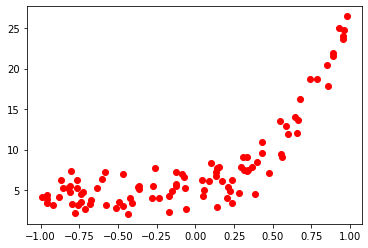

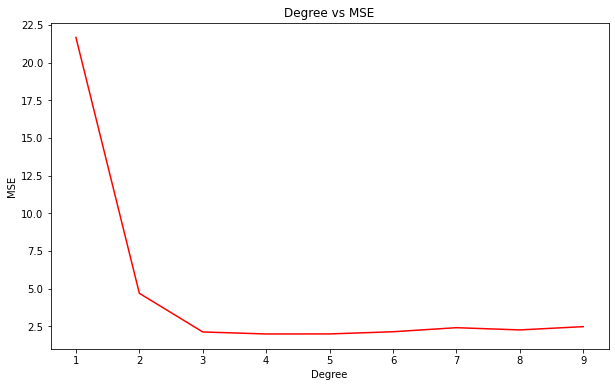

In [7]:
%matplotlib inline

def generate_dataset(n=100, degree=1, noise=1, factors=None):
    # Generates a dataset by adding random noise to a randomly
    # generated polynomial function.
    
    x = np.random.uniform(low=-1, high=1, size=n)
    
    factors = np.random.uniform(0, 10, degree+1)
    
    y = np.zeros(x.shape)
    
    for idx in range(degree+1):
        y += factors[idx] * (x ** idx)

    # add noise
    y += np.random.normal(-noise, noise, n)
    
    return x, y

# load generated data
np.random.seed(0)

X, y = generate_dataset(n=100, degree=4, noise=1.5)

plt.plot(X, y, 'r.', markersize=12)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

# create a pipeline
model = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())

# define the parameter values that should be searched
param_grid = {'polynomialfeatures__degree': np.arange(1, 10)}

# instantiate the grid
grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

# create testing and training sets
X, y = generate_dataset(n=100, degree=4, noise=1.5)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)
X_train=X_train.reshape(-1, 1)
y_train=y_train.reshape(-1, 1)
X_test=X_test.reshape(-1, 1)
y_test=y_test.reshape(-1, 1)

# fit the grid with data
grid.fit(X_train, y_train)

# view the best parameters
print(grid.best_estimator_)
best_degree = grid.best_estimator_.named_steps["polynomialfeatures"].degree
mse_test = -1*grid.score(X_test, y_test)

# fit on testing data
print(f'MSE on test set: {mse_test} for degree {best_degree}')

# plot degree vs MSE
plt.figure(figsize=(10, 6))
plt.plot(param_grid['polynomialfeatures__degree'], -1*grid.cv_results_['mean_test_score'], 'r-')
plt.title('Degree vs MSE')
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.show()

Implement polynomial regression using the `sklearn.preprocessing.PolynomialFeatures` transformation. Using the `sklearn.grid_search.GridSearchCV` class, perform a grid search of the polynomial order hyperparameter space with cross-validation and report the performance on an independent test set.

Plot a learning curve that show the validation accuracy as a function of the polynomial order. 

***Answer***: degree 4 has the lowest MSE. Thus degrees 1, 2, and 3 have a high bias and degrees 5 and higher have a high variance. This is due to the bias/variance trade-off where more complex models have a high variance but low bias. Vice versa for less complex models.

<p><font color='#770a0a'>Which models have a high bias, and which models have high variance? Motivate your answer.</font><p>
    
Repeat this experiment, this time using the diabetes dataset instead of the generated data.

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=6)),
                ('linearregression', LinearRegression())])
MSE on test set: 2777.2634851376483 for degree 6


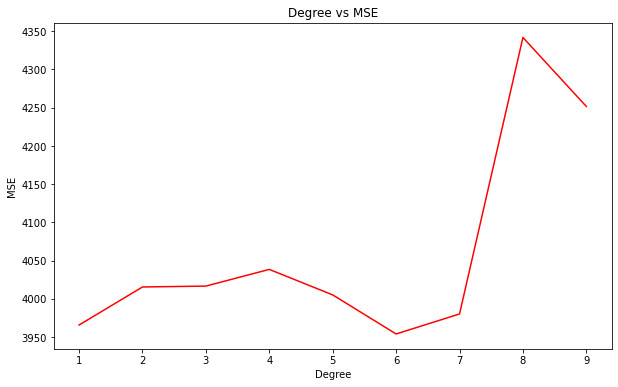

In [8]:
## With diabetes dataset

# use only one feature
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# split the data into training/testing sets
X_train = X[:-20]
X_test = X[-20:]

# split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

# create a pipeline
model = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())

# define the parameter values that should be searched
param_grid = {'polynomialfeatures__degree': np.arange(1, 10)}

# instantiate the grid
grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

# fit the grid with data
grid.fit(X_train, y_train)

# view the best parameters
print(grid.best_estimator_)
best_degree = grid.best_estimator_.named_steps["polynomialfeatures"].degree
mse_test = -1*grid.score(X_test, y_test)

# fit on testing data
print(f'MSE on test set: {mse_test} for degree {best_degree}')

# plot degree vs MSE
plt.figure(figsize=(10, 6))
plt.plot(param_grid['polynomialfeatures__degree'], -1*grid.cv_results_['mean_test_score'], 'r-')
plt.title('Degree vs MSE')
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.show()


### ROC curve analysis
A common method to evaluate binary classifiers is the receiver operating characteristic (ROC) curve. Similar to the week one practicals, implement a $k$-NN classifier on the breast cancer dataset, however, his time use the $k$-NN pipeline from the preliminary. Train the model for different values of $k$ and evaluate their respective performance with an ROC curve, use the `sklearn.metrics.roc_curve` function.

K = 1 AUC ROC = 0.929951690821256
K = 3 AUC ROC = 0.9747181964573269
K = 5 AUC ROC = 0.9821256038647342
K = 7 AUC ROC = 0.9819645732689212
K = 9 AUC ROC = 0.981159420289855


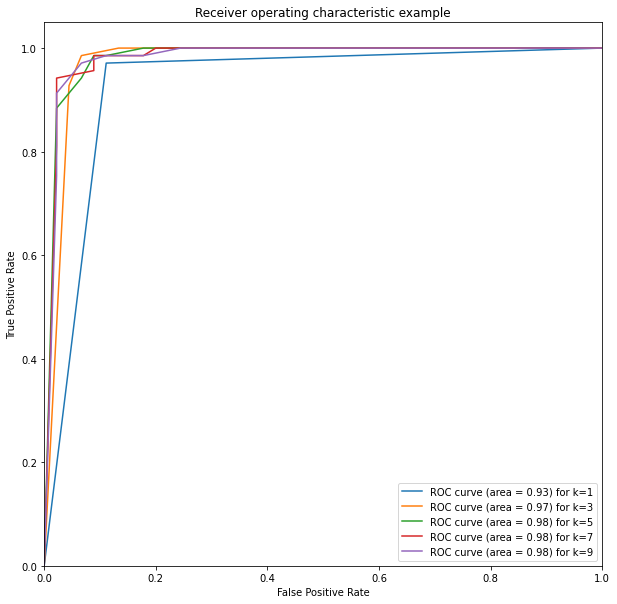

In [22]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors, svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# load in breast cancer data
breast_cancer = datasets.load_breast_cancer()

# get features and target
X = breast_cancer.data
y = breast_cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=484, shuffle=True)

# define the maximum number of k-nearest neighbors 
max_k = 10
k_range = range(1, max_k, 2)

# false positive rate, true positive rate, and auc roc score
fpr = dict()
tpr = dict()
AUC_ROC_scores = dict()

# standardize the data
scaler = StandardScaler()
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)

# training and retreiving ROC values for different values of K
for i, k in enumerate(k_range):
    # create a pipeline
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # fit the model
    knn.fit(X_train, y_train)
    
    # predict the probabilities
    y_score = knn.predict_proba(X_test)[:, 1]
    
    # calculate the false positive rate and true positive rate
    fpr[k], tpr[k], _ = roc_curve(y_test, y_score)
    
    # calculate the auc roc score
    AUC_ROC_scores[k] = auc(fpr[k], tpr[k])

#plot all the ROC curvers into one 
plt.figure(figsize=(10, 10))
for i, k in enumerate(k_range):
    print(f'K = {k} AUC ROC = {AUC_ROC_scores[k]}')
    plt.plot(fpr[k], tpr[k], label='ROC curve (area = %0.2f) for k=%i' % (AUC_ROC_scores[k], k))
    

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

### $F_1$ score and Dice similarity coefficient

The Dice similarity coefficient is a very popular evaluation measure for image segmentation applications. Assuming that $A$ is the ground truth segmentation of an object represented as a binary image, and $B$ is the binary output of an image segmentation method, the Dice similarity coefficient is computed as:

$\text{Dice}(A,B) = \frac{2|A\cap B|}{|A| + |B|}$

where $|\cdot|$ represents the cardinality of the objects (e.g. $|A|$ is the number of non-zero pixels in the ground truth segmentation).

For example, the Dice similarity can be computed in the following way:

0.3402777777777778


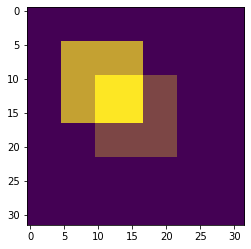

In [10]:
# generate some test objecys
A = np.zeros((32, 32))
A[10:-10, 10:-10] = 1
B = np.zeros((32, 32))
B[5:-15, 5:-15] = 1

dice = 2*np.sum(A*B)/(np.sum(A)+np.sum(B))

# display the results
plt.plot()
plt.imshow(A)
plt.imshow(B, alpha=0.7)

print(dice)

<p><font color='#770a0a'>Show that the $F_1$ score, which is the harmonic mean of precision and recall, is equivalent to the Dice similarity coefficient</font><p>

##### <span style="color:blue">Answer:</span>

Slide 146 of the week 1 extended slide set provides the formula for the $F_1$ score:
\begin{equation}
F_1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\end{equation}

Where the Precision and Recall can be written as (slide 143): 

\begin{equation}
Precision = \frac{TP}{TP+FP}
\end{equation}

\begin{equation}
Recall = \frac{TP}{TP+FN}
\end{equation}

Where TP, FP and FN are respectively the true positives, false positives and false negatives. Substituting the precision and recall into the equation for the $F_1$ score gives:

\begin{equation}
F_1 = 2 \cdot \frac{\frac{TP}{TP+FP}\cdot \frac{TP}{TP + FN}}{\frac{TP}{TP+FP}+ \frac{TP}{TP+FN}} = 2 \cdot \frac{\frac{TP^2}{(TP+FP)(TP+FN)}}{\frac{TP(TP+FN)+TP(TP+FP)}{(TP+FP)(TP+FN)}} = 2 \cdot \frac{TP^2}{TP(TP+FN) + TP(TP+FP)} = \frac{2\cdot TP}{2TP + FP + FN}
\end{equation}

The Dice similarity coefficient is given as: 

\begin{equation}
\text{Dice}(A,B) = \frac{2|A\cap B|}{|A| + |B|}
\end{equation}

$|A\cap B|$ is the intersection between A and B and is equal to TP. $|A| \text{and} |B|$ are the cardinalities of the two sets and the two combined are equal to taking the union + intersection of set A and B [1]. This is equal to 2TP+FP+FN. The previous observations lead to the conclusion that the $F_1$ score and Dice similarity coefficient are equivalent. 
\begin{equation}
\text{Dice}(A,B) = \frac{2|A\cap B|}{|A| + |B|} = \frac{2 \cdot TP}{2TP + FP + FN} = F_1
\end{equation}

The sklearn.metrics.f1_score function is used to verify if the f1_score is equal to the dice similarity coefficient for the example above. This is the case as can be seen in the calculation below. 

In [11]:
# computation F1 score
from sklearn.metrics import f1_score
F1_score = f1_score(y_true=A, y_pred=B,average='weighted',zero_division=0)
print(F1_score)

0.3402777777777778


[1] Riang, Chen (2020). *F1 Score = Dice coefficient.* Retrieved from: https://chenriang.me/f1-equal-dice-coefficient.html